In [1]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['jpg']
import matplotlib
matplotlib.figure.Figure.__repr__ = lambda self: (
    f"<{self.__class__.__name__} size {self.bbox.size[0]:g}"
    f"x{self.bbox.size[1]:g} with {len(self.axes)} Axes>")
import networkx as nx
import random
import numpy as np
import misc as ut
import numpy.ma as ma
import copy
from statistics import mean
from triFastSTMF import triFastSTMF as triFastSTMF
import networkx.algorithms.community as nx_comm
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

# Network preprocessing

In [2]:
network_name = "ant_colony"
day_min, day_max = 20, 31
G_orig = nx.read_edgelist(f'data/insecta-ant-colony3/insecta-ant-colony3.edges_avg_from_{day_min}_to_{day_max}', nodetype=int, data=(("weight", float),))
adj = nx.adjacency_matrix(G_orig)

In [3]:
non_zero = np.count_nonzero(adj.todense())
total_val = np.product(adj.todense().size)
sparsity = (total_val - non_zero) / total_val
sparsity

0.11905839746491625

In [4]:
density = non_zero / total_val
density

0.8809416025350838

In [5]:
N = len(G_orig.nodes())
N

141

In [6]:
edges = len(G_orig.edges())
edges

8757

In [7]:
G_orig.remove_node(20) # remove outlier node

In [8]:
tsne = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=5)#, early_exaggeration=5)#, n_iter=500)
emb = tsne.fit_transform(adj.todense())
pos_ = {name: emb[i] for i, name in enumerate(list(G_orig.nodes()))}

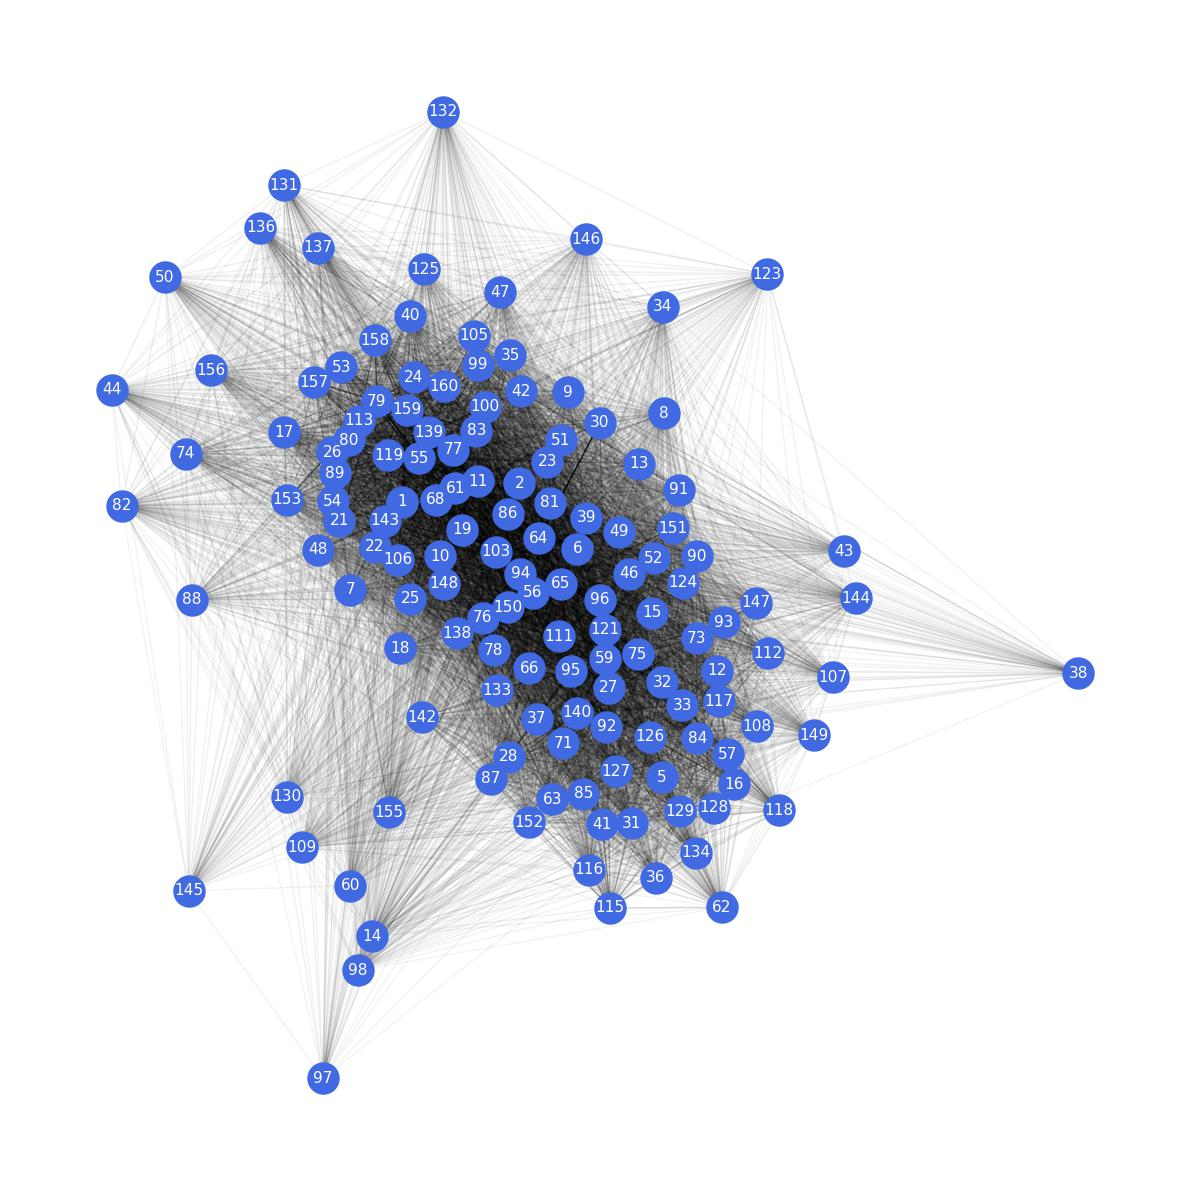

In [9]:
# graph visualization
pos = nx.spring_layout(G_orig, seed=123, k=20/np.sqrt(G_orig.order()))
#pos = pos_ # TSNE positioning
plt.figure(0, figsize=(12,12))
nx.draw_networkx_nodes(G_orig, pos=pos, node_size=500, node_color="#4169E1")
alphas = np.array([a["weight"] for u,v,a in G_orig.edges(data=True)])
alphas = alphas/np.max(alphas)
alphas = alphas+0.05
alphas[alphas>1]=1
nx.draw_networkx_edges(G_orig,pos=pos,alpha=alphas)
#print(pos)
for node, (x, y) in pos.items():
    #if node==79 or node==55:
    #    plt.text(x, y, node, fontsize=11, ha='center', va='center', color="red")
    #    continue
    plt.text(x, y, node, fontsize=11, ha='center', va='center', color="white")
plt.tight_layout()
plt.box(False)
plt.savefig("figures/"+network_name+".png", dpi=300, bbox_inches="tight")

In [10]:
nx.write_edgelist(G_orig, f'data/insecta-ant-colony3/final_graph.edges', data=["weight"])

In [11]:
adj = nx.adjacency_matrix(G_orig) # 

# Partitioning and fitting

In [12]:
print(adj.todense()) # 0 is missing value

[[0.         1.5        1.33333333 ... 0.         0.         0.33333333]
 [1.5        0.         8.58333333 ... 0.41666667 5.41666667 0.66666667]
 [1.33333333 8.58333333 0.         ... 0.         1.33333333 1.08333333]
 ...
 [0.         0.41666667 0.         ... 0.         0.5        0.16666667]
 [0.         5.41666667 1.33333333 ... 0.5        0.         0.41666667]
 [0.33333333 0.66666667 1.08333333 ... 0.16666667 0.41666667 0.        ]]


In [13]:
np.max(adj.todense())

139.33333333333334

In [14]:
np.min(adj.todense())

0.0

In [15]:
init_stmf="fixed"
dataset = 1
threshold=5 # 300 seconds for repeating experiments
repeat = 1 # 1 run is enough since everything is fixed

In [16]:
datasets = list(range(10))
data = []
approx_errors, prediction_errors = [], []
# only X-Z
approx_errors_xz, prediction_errors_xz = [], []
for i in datasets:
    print(i)
    # Construct graph
    G = ut.return_graph(f"data/insecta-ant-colony3/matrices/insecta-ant-colony3.newedges_{i}", G_orig.nodes())
    G_mapping = {n: list(G.nodes()).index(n) for n in list(G.nodes())}
    N = len(G.nodes())
    
    # Construct prediction and approximation matrices
    Pred_M = (nx.adjacency_matrix(G_orig) - nx.adjacency_matrix(G)).todense()
    Appr_M = nx.adjacency_matrix(G).todense()#nx.adjacency_matrix(G_orig).todense() - Pred_M
    mask_approx = Pred_M > 0
    mask_predict = Pred_M == 0
    appr_M = ma.masked_array(Appr_M, mask_approx)
    pred_M = ma.masked_array(Pred_M, mask_predict)
    
    X_indices, Y_indices, W_indices, Z_indices, indices, F_mapping = ut.compute_matrices(G) # louvain partitioning
    print(indices)
    m, n = indices[0], indices[3]
    rank_1, rank_2 = indices[1], indices[2]
    R, G_1, S, G_2 = ut.get_matrices(nx.adjacency_matrix(G), X_indices, Y_indices, W_indices, Z_indices)
    d = np.array(R.todense().flatten())[0]
    data.append(d)
    R, G_1, S, G_2 = ut.convert_sparse_to_dense(R, param="data"), ut.convert_sparse_to_dense(G_1), ut.convert_sparse_to_dense(S), ut.convert_sparse_to_dense(G_2)
    R, G_1, G_2 = ut.check_empty_rows_columns(R, G_1, G_2, rank_1, rank_2)
    ####
    model_trifaststmf = triFastSTMF(rank_1 = rank_1, rank_2 = rank_2, initialization=init_stmf, threshold=threshold, fixed_U=G_1, fixed_X=S, fixed_V=G_2)
    model_trifaststmf.fit(R)
    factor_G1, factor_S, factor_G2 = model_trifaststmf.U, model_trifaststmf.X, model_trifaststmf.V
    ####
    trifact_adj = ut.convert_trifact_to_adj(N, factor_G1, factor_S, factor_G2, G_mapping, F_mapping)
    trifact_adj_R = ut.convert_trifact_to_adj_R(N, factor_G1, factor_S, factor_G2, G_mapping, F_mapping)
    mask_R = trifact_adj_R.mask
    mask_approx_R = np.logical_or(mask_R, mask_approx)
    mask_pred_R = np.logical_or(mask_R, mask_predict)
    appr_M_R = ma.masked_array(Appr_M, mask_approx_R)
    pred_M_R = ma.masked_array(Pred_M, mask_pred_R)
    ####
    trifact_adj_approx = ma.masked_array(trifact_adj, mask_approx)
    trifact_adj_predict = ma.masked_array(trifact_adj, mask_predict)
    approx_error = ut.rmse(appr_M, trifact_adj_approx)
    prediction_error = ut.rmse(pred_M, trifact_adj_predict)
    app_R = ut.rmse(appr_M_R, trifact_adj_R)
    pred_R = ut.rmse(pred_M_R, trifact_adj_R)
    ####
    approx_errors.append(approx_error)
    prediction_errors.append(prediction_error)
    approx_errors_xz.append(app_R)
    prediction_errors_xz.append(pred_R)

0
[65, 21, 2, 52]
(65, 52)
1
[57, 22, 5, 56]
(57, 56)
2
[57, 24, 2, 57]
(57, 57)
3
[60, 21, 2, 57]
(60, 57)
4
[60, 20, 4, 56]
(60, 56)
5
[61, 19, 2, 58]
(61, 58)
6
[57, 18, 15, 50]
(57, 50)
7
[52, 23, 14, 51]
(52, 51)
8
[67, 4, 2, 67]
(67, 67)
9
[65, 15, 2, 58]
(65, 58)


In [19]:
#approx_errors, prediction_errors

In [20]:
#approx_errors_xz, prediction_errors_xz